In [10]:
from fastai2.vision.all import *
from fastai2_audio.all import *
from siren import siren_model

In [22]:
# Helper function
def decode_prediction(learner, inp, sampling_rate=16000): 
    out = learner.model(inp.cuda())
    out = AudioTensor(out.transpose(0, 1).cpu(), sr=sampling_rate)
    return out

# Loading the data

In [11]:
audio = AudioTensor.create("Samples/LapsBM-F006-LapsBM_0101.wav")

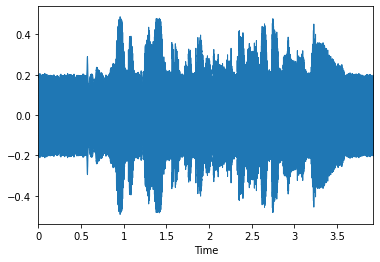

In [12]:
audio.show(hear=True)

In [13]:
print(f"""This audio has a sampling rate of {audio.sr}, {audio.nchannels} channel(s) and a length of {audio.nsamples} samples""")

This audio has a sampling rate of 16000, 1 channel(s) and a length of 62787 samples


# Preparing the Dataset

Each sample in the audio file will correspond to one training example

In [14]:
y = audio.transpose(0, 1)
y.shape

torch.Size([62787, 1])

The input to this model will be the time, normalized to the appropriated range.

According to the section 8.1 in the appendix of the paper (page 29):
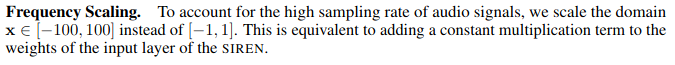

In [15]:
x = torch.arange(-100, 100, step=200/62787).unsqueeze(1)
x.shape

torch.Size([62787, 1])

Now creating the dataset (time) -> (audio amplitude)

In [16]:
from torch.utils.data import TensorDataset, random_split
dset = TensorDataset(x.cuda(), y.cuda())

Random splitting the data so 20% of them are used for validation

In [17]:
val_pct = 0.2
val_len = int(len(dset)*val_pct)
lengths = [len(dset)-val_len, val_len]
train_dset, val_dset = random_split(dset, lengths)

In [18]:
dls = DataLoaders(DataLoader(train_dset, bs=8 * 2048), DataLoader(val_dset, bs=8 * 2048))

# Creating the model, optimizer and loss

In [29]:
learn = Learner(dls, 
    siren_model([1, 256, 256, 256, 256, 1]).cuda(), 
    loss_func=MSELossFlat(),
    opt_func=ranger           
    )

In [20]:
learn.model

Sequential(
  (0): Sequential(
    (0): Linear(in_features=1, out_features=256, bias=True)
    (1): Siren(w0=30)
  )
  (1): Sequential(
    (0): Linear(in_features=256, out_features=256, bias=True)
    (1): Siren(w0=1)
  )
  (2): Sequential(
    (0): Linear(in_features=256, out_features=256, bias=True)
    (1): Siren(w0=1)
  )
  (3): Sequential(
    (0): Linear(in_features=256, out_features=256, bias=True)
    (1): Siren(w0=1)
  )
  (4): Sequential(
    (0): Linear(in_features=256, out_features=1, bias=True)
    (1): Siren(w0=1)
  )
)

SuggestedLRs(lr_min=0.002290867641568184, lr_steep=0.0020892962347716093)

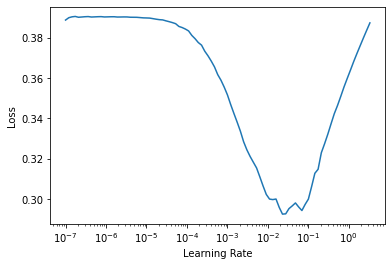

In [21]:
learn.lr_find()

# Starting the training

In [30]:
learn.fit_flat_cos(200, lr=1e-3)

epoch,train_loss,valid_loss,time
0,0.395497,0.390400,00:02
1,0.392089,0.350611,00:02
2,0.360262,0.311026,00:02
3,0.330922,0.220363,00:02
4,0.300294,0.187643,00:02
5,0.272549,0.168387,00:02
6,0.248404,0.131111,00:02
7,0.226505,0.116428,00:02
8,0.207318,0.108132,00:02
9,0.190288,0.089249,00:02


This is the result of the model after training with 80% of the data. If you listen, the high noise present in the original recording is more noticeable, but it's still possible to hear the voice and understand what it's saying. Maybe with more training it will fit the data better?

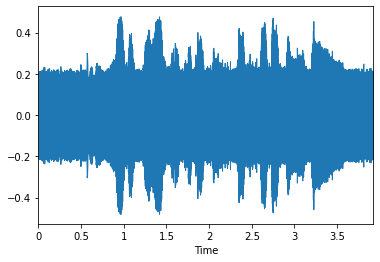

In [31]:
out = decode_prediction(learn, x)
out.show()

Original audio, so you can compare

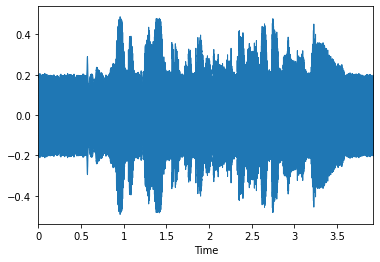

In [85]:
audio.show()